## Feature Selection

This '.ipynb' file contains some agressive feature selection to reduce the total of a litte over 32000 features down to a manageble count valuable for training. This wil be done trough various methods:

- Inital feature selection of clinical data
- Dropping duplicates
- Dropping NaN values
- Mixed Data types
- Fracting thresholding
- Variance thresholding
- Correlation thresholding
- Lasso regression
- KBest selection
- More...

By aplying al of these feature reducing methods whe hope to reduce the total feature count to a maximun of a couple honderd to a thousend features.

#### 1. Understanding the dataset
The preprocessed dataset is loaded in, and two small functions are defined to retrieve the clinical and gene columns respectably. Some general information is printed to the screen to get a general sense of the scale and size op de dataset. Next to this a small graph is plotted to view the distribution of the histology types.

Gene columns (33764): ['LINC01587_unstranded', 'AC000061.1_unstranded', 'AC016026.1_unstranded', 'IGF2-AS_unstranded', 'RRN3P2_unstranded', 'AC087235.1_unstranded', 'DLEU2L_unstranded', 'PINK1-AS_unstranded', 'SPART-AS1_unstranded', 'LINC00544_unstranded', 'KIAA0087_unstranded', 'AC105760.1_unstranded', 'MYRF-AS1_unstranded', 'MIR9-1HG_unstranded', 'LINC00029_unstranded', 'FAM182A_unstranded', 'LINC02871_unstranded', 'C22orf24_unstranded', 'TTTY1B_unstranded', 'TTTY1_unstranded', 'H19_unstranded', 'TTTY9B_unstranded', 'AC091132.1_unstranded', 'TTTY6_unstranded', 'TTTY6B_unstranded', 'LINC00470_unstranded', 'AL139352.1_unstranded', 'C7orf69_unstranded', 'AL355922.1_unstranded', 'AC027088.1_unstranded', 'AC062028.1_unstranded', 'CCDC39_unstranded', 'LINC01558_unstranded', 'LINC00525_unstranded', 'TTTY7_unstranded', 'TTTY7B_unstranded', 'SCP2D1-AS1_unstranded', 'LINC00266-1_unstranded', 'AL136982.1_unstranded', 'PART1_unstranded', 'LINC00467_unstranded', 'ZFHX2-AS1_unstranded', 'TUBA3FP_u

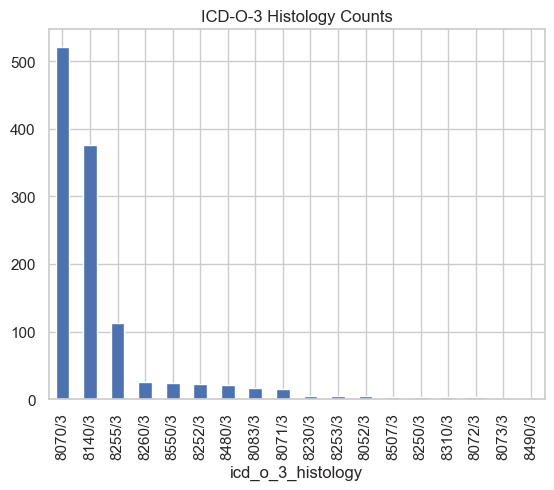

In [628]:
import pandas as pd

# Loading the preprocessed dataset
dataFrame: pd.DataFrame = pd.read_csv('./DatasetParser/Dataset/ProcessedFiles/merged_data.csv', low_memory=False)

# Function to get all columns related to genes
def getGeneColumns():
    return [col for col in dataFrame.columns if 'unstranded' in col]

def getClinicalColumns():
    geneColumns: set[str] = set(getGeneColumns())
    return [col for col in dataFrame.columns if col not in geneColumns]

# Selecting all the unstranded and tpm_unstranded columns
geneColumns: list[str] = getGeneColumns()

# Selecting all the clinical columns
allClinicalColumns: list[str] = getClinicalColumns()

print(f"Gene columns ({len(geneColumns)}): {geneColumns}")
print(f"Clinical columns ({len(allClinicalColumns)}): {allClinicalColumns}")
print(f"Total columns in the dataset: {len(dataFrame.columns)}")

# Printing the row count of the dataset
print(f"\nTotal rows in the dataset: {len(dataFrame)}")

targetColumn: str = 'icd_o_3_histology'

# Defining the clinical columns to be retained
clinicalColumns: list[str] = [targetColumn]

# Checking rows for NaN values in specific columns
selectedColumns: list[str] = clinicalColumns + geneColumns

# Plotting the icd_o_3_histology column count distribution in graph format
histologyCounts = dataFrame[targetColumn].value_counts()
histologyCounts.plot(kind='bar', title='ICD-O-3 Histology Counts')

print(dataFrame.loc[0:1, clinicalColumns])


#### 2. NaN, Duplicates, Mixed data types

First the preprocessed dataset is checked for duplicates based on the "case_id", only one row should be availible for each case. Next any rows containing NaN values are dropped. Lastly the gene features are checked for mixed data types. Any rows with mixed data types wil be removed. These step together make sure that the ML models have a proper format for train with.

In [629]:
# Saving the orginal dataset size
oldRowCount: int = len(dataFrame)

# Retrieving all the unique cases from the dataset
dataFrame.drop_duplicates(subset=['case_id'], inplace=True)

# Keeping only the selected columns
dataFrame = dataFrame[selectedColumns]

# Difference calculation for duplicate rows
duplicateRowCount: int = oldRowCount - len(dataFrame)

# Dropping rows with any NaN values
dataFrame.dropna(inplace=True)

# Difference calculation for NaN rows
nanRowCount: int = oldRowCount - duplicateRowCount - len(dataFrame)

# Identifying columns with mixed data types
mixedTypeColumns: list[str] = [
    col for col in dataFrame.columns
    if dataFrame[col].map(type).nunique() > 1
]

# Dropping columns with mixed data types
dataFrame.drop(columns=mixedTypeColumns, inplace=True)

# Keeping the gene columns up-to-date
geneColumns = getGeneColumns()

# Difference calculation for mixed type rows
mixedTypeRowCount: int = oldRowCount - duplicateRowCount - nanRowCount - len(dataFrame)

# Retrieving the final row count after all operations
newRowCount: int = len(dataFrame)

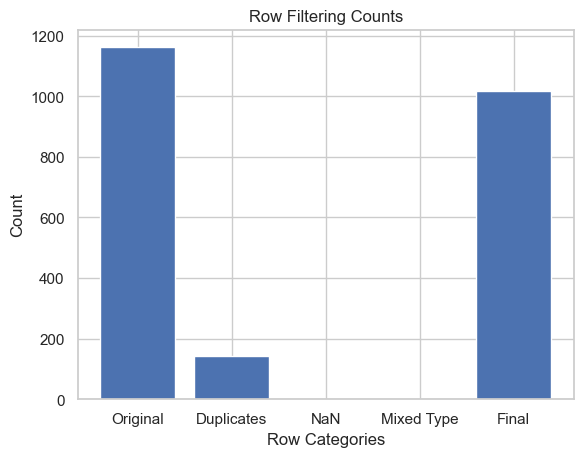

Original row count: 1162
Duplicate rows removed: 144
Rows with NaN values removed: 0
Mixed type rows removed: 0
Final row count after processing: 1018


In [630]:
import matplotlib.pyplot as plt

# Plotting a bar chart with diplicate, nan and final row counts
plt.bar(['Original', 'Duplicates', 'NaN', 'Mixed Type','Final'], 
        [oldRowCount, duplicateRowCount,nanRowCount, mixedTypeRowCount,newRowCount])
plt.title('Row Filtering Counts')
plt.xlabel('Row Categories')
plt.ylabel('Count')
plt.show()

# Printing the stats in text format
print(f"Original row count: {oldRowCount}")
print(f"Duplicate rows removed: {duplicateRowCount}")
print(f"Rows with NaN values removed: {nanRowCount}")
print(f"Mixed type rows removed: {mixedTypeRowCount}")
print(f"Final row count after processing: {newRowCount}")

#### 3. Categorising the histology types

In [631]:
# Initializing the histology column to classify histology types
dataFrame[targetColumn] = dataFrame[targetColumn].astype(str)

# Defining sets to identify histology types in each category
squamousCodes: set = set()
adenocarcinomaCodes: set = set()
otherHistologyCodes: set = set()
invalidHistologyCodes: set = set()

def classify_histology(icdCode: str) -> int:
    global otherCount, squamousCodes, adenocarcinomaCodes

    try:
        # Retrieving the numerical main code from the ICD-O-3 histology code
        mainCode = int(icdCode.split("/")[0])
    except:
        invalidHistologyCodes.add(icdCode)
        return None
    if  8050 <= mainCode <= 8084:
        squamousCodes.add(icdCode)
        return 0  # Squamous
    elif 8140 <= mainCode <= 8576:
        adenocarcinomaCodes.add(icdCode)
        return 1  # Adenocarcinoma
    
    # Other histology types will be counted towards Adenocarcinoma
    otherHistologyCodes.add(icdCode)
    return 2

# Dropping possible invalid histology codes
dataFrame.dropna(subset=[targetColumn], inplace=True)

# Classifying histology types and updating the histology column
dataFrame[targetColumn] = dataFrame[targetColumn].apply(classify_histology).astype("category")

# Displaying the unique histology types and their counts
print('Squamous Codes:', squamousCodes)
print('Adenocarcinoma Codes:', adenocarcinomaCodes)
print('Other Histology Codes:', otherHistologyCodes)
print('Invalid Histology Codes:', invalidHistologyCodes)

Squamous Codes: {'8072/3', '8071/3', '8083/3', '8070/3', '8052/3', '8073/3'}
Adenocarcinoma Codes: {'8550/3', '8480/3', '8507/3', '8255/3', '8250/3', '8260/3', '8490/3', '8252/3', '8310/3', '8253/3', '8140/3', '8230/3'}
Other Histology Codes: set()
Invalid Histology Codes: set()


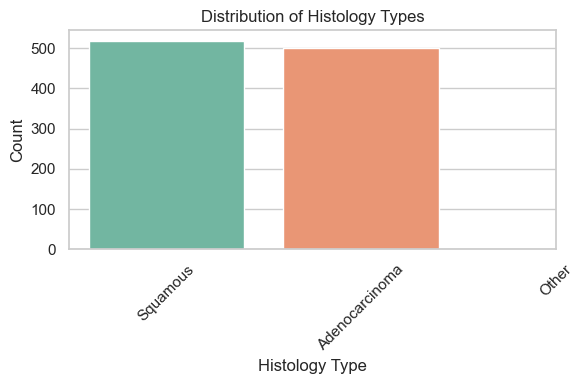

Squamous Count: 500
Adenocarcinoma Count: 518
Other Histology Count: 0


In [632]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a small graph to visualize the distribution of histology types
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=dataFrame[targetColumn].astype(str), palette="Set2", hue=dataFrame[targetColumn].astype(str))
plt.title('Distribution of Histology Types')
plt.xlabel('Histology Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Squamous', 'Adenocarcinoma', 'Other'], rotation=45)
plt.tight_layout()
plt.show()

# Displaying the distribution of histology types
print('Squamous Count:', dataFrame[targetColumn].value_counts().get(0, 0))
print('Adenocarcinoma Count:', dataFrame[targetColumn].value_counts().get(1, 0))
print('Other Histology Count:', dataFrame[targetColumn].value_counts().get(2, 0))

### 4. Fraction Threshold

Any genes that where 80% of the sampels have a value lower that 80% wil be dropped, these genes likely do not play a large role in detecting histology subtypes.

In [633]:
# A dictionary to map the feature selection steps to show progression in fearure reduction
featureSelectionSteps: dict = {"Initial": len(dataFrame.columns)}

countThreshold: int = 5 # TODO find logical value
sampleFractionThreshold: float = 0.8 # TODO find logical value

# Creating a mask for the data frame so only the active genes are included
lowCountmask = (dataFrame[geneColumns] < countThreshold).sum(axis=0) > (sampleFractionThreshold * dataFrame[geneColumns].shape[0])

# Creating a filterd data frame
filteredDataFrame: pd.DataFrame = dataFrame[geneColumns].loc[:, ~lowCountmask]

# Updating the gene columns to ensure correct indexing
geneColumns = filteredDataFrame.columns

# Updating the original dataframe
dataFrame = dataFrame[clinicalColumns].join(filteredDataFrame)

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Fraction Threshold"] = len(dataFrame.columns)

#### 5. Variance threshold

Small variance between gene samples have litte to no value to the global model training and can be dropped.

In [634]:
from sklearn.feature_selection import VarianceThreshold

# Define a threshold for variance
varianceThreshold: int = 15  # TODO find logical value

# Step 1: Select only the feature columns (ensure no NaNs)
threshHoldDataFrame: pd.DataFrame = dataFrame[geneColumns].copy()

# Step 2: Apply VarianceThreshold
selector = VarianceThreshold(threshold=varianceThreshold)
xSelected = selector.fit_transform(threshHoldDataFrame)

# Step 3: Get selected column names
selectedColumns: list[str] = threshHoldDataFrame.columns[selector.get_support()]

# Step 4: Create a new DataFrame with selected features
filteredDataFrame = pd.DataFrame(xSelected, columns=selectedColumns, index=dataFrame.index)

# Step 5: Drop original gene columns and add the reduced set
dataFrame = dataFrame[clinicalColumns].join(filteredDataFrame)

# Updating the geneColumns to reflect the reduced set
geneColumns = selectedColumns

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Variance Threshold"] = len(dataFrame.columns)

#### 6. Standart scaler (Data split)

In [ ]:
from sklearn.preprocessing import StandardScaler

def getDataXAndY(dataFrame: pd.DataFrame, targetColumn: str):
    # Splits the DataFrame into features (X) and target (y).
    X = dataFrame.drop(columns=[targetColumn])  # All features except the target
    y = dataFrame[targetColumn]  # Target variable
    return X, y

X, y = getDataXAndY(dataFrame, targetColumn)

# Scale the features (Lasso is sensitive to scale)
scaler = StandardScaler()
xScaled = scaler.fit_transform(X)

#### 7. Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lassoThreshold: float = 0.01  # TODO find logical value

# 1. Fit Lasso and SelectFromModel
lasso = Lasso(alpha=lassoThreshold)
selector = SelectFromModel(lasso)
selector.fit(xScaled, y)

# 2. Get selected feature mask
lowCountmask = selector.get_support()

# 3. Use mask to trim original DataFrame (preserving column names)
selected_features = X.columns[lowCountmask]
dataFrame = X[selected_features]

# join the icd_o_3_histology column back
dataFrame = dataFrame.join(y)

geneColumns = getGeneColumns()

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Lasso Threshold"] = len(dataFrame.columns)

#### 8. Correlation threshold

Any correlated features have litte to no extra value to be includeded in model training and can be dropped.

In [636]:
# Defining a threshold for correlation
correlationThreshold: float = 0.75 

# Creating a correlation matrix
correlationMatrix = dataFrame[geneColumns].corr()

# Finding pairs of columns with correlation above the threshold
selectedColumns = set()
for i in range(len(correlationMatrix.columns)):
    for j in range(i):
        if abs(correlationMatrix.iloc[i, j]) > correlationThreshold:
            colname = correlationMatrix.columns[i]
            selectedColumns.add(colname)

# Dropping the selected columns from the original DataFrame
dataFrame.drop(columns=selectedColumns, inplace=True)

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Correlation Threshold"] = len(dataFrame.columns)

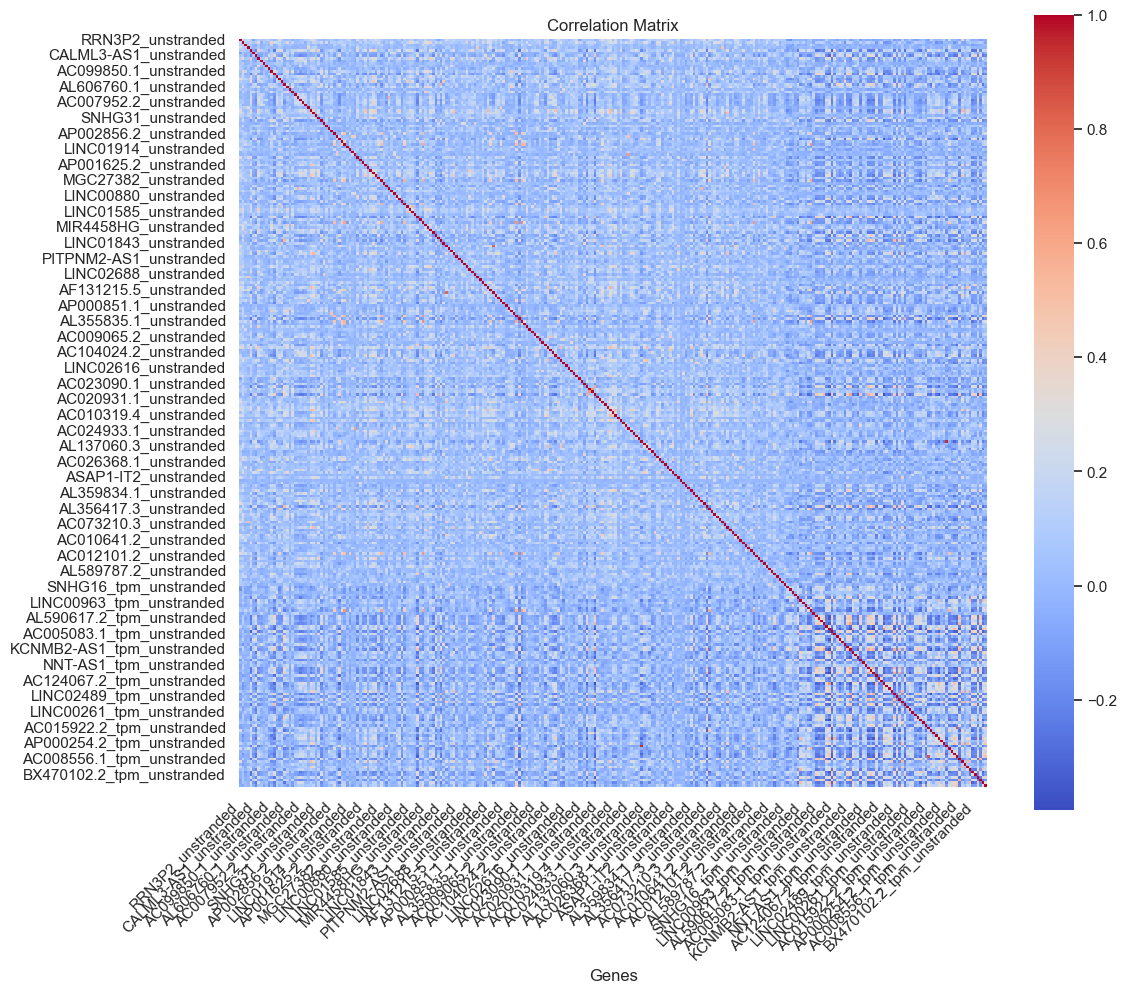

In [637]:
import seaborn as sns
import matplotlib.pyplot as plt

# plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
# Hide value labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel('Genes')

plt.title('Correlation Matrix')
plt.show()

#### 9. Select K Best

In [638]:
from sklearn.feature_selection import SelectKBest, f_classif

X, y = getDataXAndY(dataFrame, targetColumn)

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

lowCountmask = selector.get_support()
selected_feature_names = X.columns[lowCountmask]

# Trim the DataFrame
dataFrame = X[selected_feature_names]

# join the icd_o_3_histology column back
dataFrame = dataFrame.join(y)

geneColumns = getGeneColumns()

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["SelectKBest"] = len(dataFrame.columns)

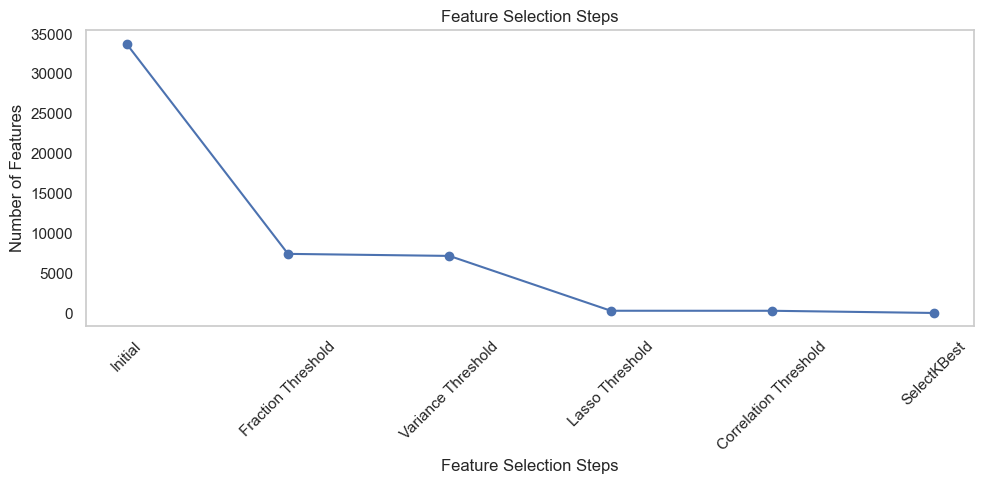

In [639]:
# Plotting a line graph to show the feature selection steps
plt.figure(figsize=(10, 5))
plt.plot(list(featureSelectionSteps.keys()), list(featureSelectionSteps.values()), marker='o')
plt.title('Feature Selection Steps')
plt.xlabel('Feature Selection Steps')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### 10. Model training

Accuracy: 0.9084967320261438
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91        82
           1       0.86      0.96      0.91        71

    accuracy                           0.91       153
   macro avg       0.91      0.91      0.91       153
weighted avg       0.91      0.91      0.91       153



Text(0.5, 0, 'False Positive Rate')

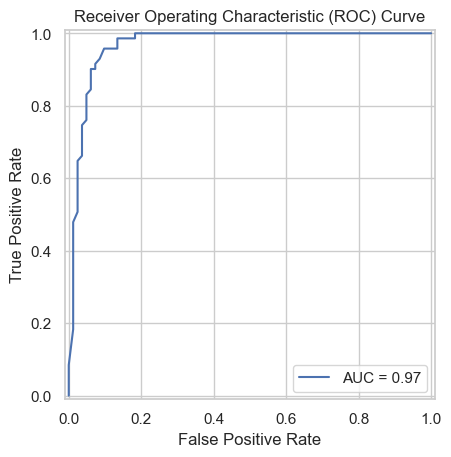

In [640]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

randomSeed: int = 645

# Training a random forest classifier and splitting the data into training and testing sets
X, y = getDataXAndY(dataFrame, targetColumn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=randomSeed)

rf = RandomForestClassifier(random_state=randomSeed)
rf.fit(X_train, y_train)

# Evaluating the model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# plotting roc and using the AUC score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')

In [641]:
# TRaining and testing alogistical regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000, random_state=randomSeed)
log_reg.fit(X_train, y_train)
# Evaluating the logistic regression model
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.9084967320261438


In [642]:
# training ans testing a support vector machine model
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=randomSeed)
svm_model.fit(X_train, y_train)
# Evaluating the SVM model
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.8954248366013072
